In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.offline as py
import plotly.graph_objs as go
from scipy import stats
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, auc, roc_curve
import gc
import time

# Data exploration
First we will explore the data for insights

## Application table

In [2]:
application_train = pd.read_csv('./datasets/application_train.csv')
application_test = pd.read_csv('./datasets/application_test.csv')

application_all = pd.concat([application_train.drop(columns=['TARGET'],axis = 1),application_test], sort=True)

In [3]:
application_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE              object
CODE_GENDER                     object
FLAG_OWN_CAR                    object
FLAG_OWN_REALTY                 object
CNT_CHILDREN                    int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                 object
NAME_INCOME_TYPE                object
NAME_EDUCATION_TYPE             object
NAME_FAMILY_STATUS              object
NAME_HOUSING_TYPE               object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                      int64
DAYS_EMPLOYED                   int64
DAYS_REGISTRATION               float64
DAYS_ID_PUBLISH                 int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                   

In [4]:
pd.options.display.max_columns = None
application_train.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

We can see that we have a lot of columns. This means that there is a possible dimensionality reduction to be done here.
We can also observe that we have a some missing data. We should look and see how many missing values we have and how we should deal with them.
Finally, we can see that we have a lot of categorical features. We should analyse them in order to come up with a proper encoding. 

### Data balance

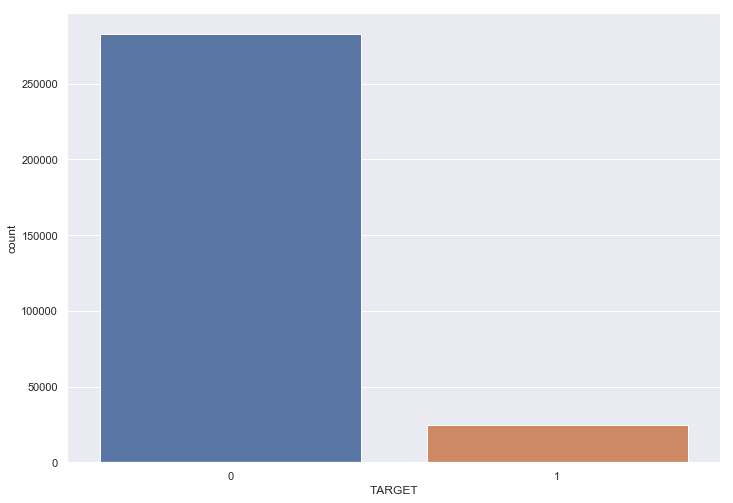

In [5]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.countplot(x="TARGET", data=application_train)

We can see that our data is highly skewed! (most applicants didn't have any payment difficulties)

---

### Missing values

In [6]:
def list_missing_data(df):
    total = df.isnull().sum().sort_values(ascending = False)
    percent = ((total/df.SK_ID_CURR.count())*100).sort_values(ascending = False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', '%'], sort=True)
    missing_data = missing_data[(missing_data['%'] > 0)]
    return missing_data.sort_values(by='%', ascending=False)

missing_data_list = list_missing_data(application_all)
missing_data_list.head(50)

,Total,%
COMMONAREA_AVG,248360,69.714109
COMMONAREA_MODE,248360,69.714109
COMMONAREA_MEDI,248360,69.714109
NONLIVINGAPARTMENTS_AVG,246861,69.293343
NONLIVINGAPARTMENTS_MEDI,246861,69.293343
NONLIVINGAPARTMENTS_MODE,246861,69.293343
FONDKAPREMONT_MODE,243092,68.235393
LIVINGAPARTMENTS_AVG,242979,68.203674
LIVINGAPARTMENTS_MEDI,242979,68.203674
LIVINGAPARTMENTS_MODE,242979,68.203674


For now, we will not be using most of the columns with more than 60% missing values.

In [7]:
columns_to_ignore = missing_data_list[missing_data_list['%']>60].index.tolist()
columns_to_ignore
#application_train.drop(columns=columns_to_drop,axis = 1, inplace = True)

['COMMONAREA_AVG',
 'COMMONAREA_MODE',
 'COMMONAREA_MEDI',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_MODE',
 'FONDKAPREMONT_MODE',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAPARTMENTS_MODE',
 'FLOORSMIN_MODE',
 'FLOORSMIN_MEDI',
 'FLOORSMIN_AVG',
 'YEARS_BUILD_MODE',
 'YEARS_BUILD_MEDI',
 'YEARS_BUILD_AVG',
 'OWN_CAR_AGE']

### Outliers
We will now see if there are any outliers in the data (extreme/weird values..) 

#### CODE_GENDER

In [8]:
application_train['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [9]:
application_test['CODE_GENDER'].value_counts()

F    32678
M    16066
Name: CODE_GENDER, dtype: int64

We have a 4 rows with the CODE_GENDER value 'XNA' in the training set, we will remove them.

In [10]:
application_train = application_train[application_train['CODE_GENDER'] != 'XNA']
application_train['CODE_GENDER'].value_counts()

F    202448
M    105059
Name: CODE_GENDER, dtype: int64

#### NAME_FAMILY_STATUS

In [11]:
application_train['NAME_FAMILY_STATUS'].value_counts()

Married                 196429
Single / not married     45444
Civil marriage           29774
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64

In [12]:
application_test['NAME_FAMILY_STATUS'].value_counts()

Married                 32283
Single / not married     7036
Civil marriage           4261
Separated                2955
Widow                    2209
Name: NAME_FAMILY_STATUS, dtype: int64

We have two people with 'Unknown' status in the training set, we will remove them.

In [13]:
application_train = application_train[application_train['NAME_FAMILY_STATUS'] != 'Unknown']
application_train['NAME_FAMILY_STATUS'].value_counts()

Married                 196429
Single / not married     45444
Civil marriage           29774
Separated                19770
Widow                    16088
Name: NAME_FAMILY_STATUS, dtype: int64

#### CNT_CHILDREN

In [14]:
application_all['CNT_CHILDREN'].describe() # 20 children?! Why not ..

count    356255.000000
mean          0.414316
std           0.720378
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: CNT_CHILDREN, dtype: float64

In [15]:
del application_all
gc.collect()

36

#### DAYS_EMPLOYED

In [16]:
(application_train['DAYS_EMPLOYED']/-365).describe() 

count    307505.000000
mean       -174.839312
std         387.059825
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [17]:
(application_test['DAYS_EMPLOYED']/-365).describe() 

count    48744.000000
mean      -184.891415
std        395.475362
min      -1000.665753
25%          0.810959
50%          3.542466
75%          7.972603
max         47.843836
Name: DAYS_EMPLOYED, dtype: float64

Here we have a wrong value for the current emplyment duration. We will remove this value

There are a lot of rows with this value. We will replace it with NaN for now, and later, when we will bin the column, we will place them in a seperate bin.

In [18]:
application_train['DAYS_EMPLOYED'] = application_train['DAYS_EMPLOYED'].replace(365243, np.NaN)
(application_train['DAYS_EMPLOYED']/-365).describe() 

count    252131.000000
mean          6.531933
std           6.406388
min          -0.000000
25%           2.101370
50%           4.515068
75%           8.698630
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [19]:
application_test['DAYS_EMPLOYED'] = application_test['DAYS_EMPLOYED'].replace(365243, np.NaN)
(application_test['DAYS_EMPLOYED']/-365).describe() 

count    39470.000000
mean         6.785586
std          6.323189
min          0.002740
25%          2.358904
50%          4.835616
75%          9.119863
max         47.843836
Name: DAYS_EMPLOYED, dtype: float64

#### OCCUPATION_TYPE

In [20]:
application_train['OCCUPATION_TYPE'].value_counts()

Laborers                 55186
Sales staff              32102
Core staff               27569
Managers                 21370
Drivers                  18603
High skill tech staff    11380
Accountants               9812
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2092
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

In [21]:
application_test['OCCUPATION_TYPE'].value_counts()

Laborers                 8655
Sales staff              5072
Core staff               4361
Managers                 3574
Drivers                  2773
High skill tech staff    1854
Accountants              1628
Medicine staff           1316
Security staff            915
Cooking staff             894
Cleaning staff            656
Private service staff     455
Low-skill Laborers        272
Secretaries               213
Waiters/barmen staff      178
Realty agents             138
HR staff                  104
IT staff                   81
Name: OCCUPATION_TYPE, dtype: int64

We have the same categories for train/test sets

#### ORGANIZATION_TYPE

In [22]:
application_train['ORGANIZATION_TYPE'].value_counts()

Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11192
Business Entity Type 2    10552
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6879
Construction               6721
Business Entity Type 1     5983
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3277
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7           1307
Transpor

In [23]:
application_test['ORGANIZATION_TYPE'].value_counts()

Business Entity Type 3    10840
XNA                        9274
Self-employed              5920
Other                      2707
Medicine                   1716
Government                 1508
Business Entity Type 2     1479
Trade: type 7              1303
School                     1287
Construction               1039
Kindergarten               1038
Business Entity Type 1      887
Transport: type 4           884
Trade: type 3               578
Military                    530
Industry: type 9            499
Industry: type 3            489
Security                    472
Transport: type 2           448
Police                      441
Housing                     435
Industry: type 11           416
Bank                        374
Security Ministries         341
Services                    302
Postal                      294
Agriculture                 292
Restaurant                  284
Trade: type 2               242
University                  221
Industry: type 7            217
Industry

#### AMT_INCOME_TOTAL

In [24]:
application_train['AMT_INCOME_TOTAL'].describe() 

count    3.075050e+05
mean     1.687967e+05
std      2.371248e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64

In [25]:
application_test['AMT_INCOME_TOTAL'].describe() 

count    4.874400e+04
mean     1.784318e+05
std      1.015226e+05
min      2.694150e+04
25%      1.125000e+05
50%      1.575000e+05
75%      2.250000e+05
max      4.410000e+06
Name: AMT_INCOME_TOTAL, dtype: float64

We have some outliers in the training data (people making over 1M).

**Decomposition in the train set:**

In [26]:
print('Number of clients making more than 1M: {}'.format(application_train.AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 1000000)].count()))
print('Number of clients making more than 2M: {}'.format(application_train.AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 2000000)].count()))
print('Number of clients making more than 4M: {}'.format(application_train.AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 4000000)].count()))
print('Number of clients making more than 10M: {}'.format(application_train.AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 10000000)].count()))
print('Number of clients making more than 100M: {}'.format(application_train.AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 100000000)].count()))

Number of clients making more than 1M: 250
Number of clients making more than 2M: 44
Number of clients making more than 4M: 9
Number of clients making more than 10M: 3
Number of clients making more than 100M: 1


**Decomposition in the test set:**

In [27]:
print('Number of clients making more than 1M: {}'.format(application_test.AMT_INCOME_TOTAL[(application_test.AMT_INCOME_TOTAL > 1000000)].count()))
print('Number of clients making more than 2M: {}'.format(application_test.AMT_INCOME_TOTAL[(application_test.AMT_INCOME_TOTAL > 2000000)].count()))
print('Number of clients making more than 4M: {}'.format(application_test.AMT_INCOME_TOTAL[(application_test.AMT_INCOME_TOTAL > 4000000)].count()))
print('Number of clients making more than 10M: {}'.format(application_test.AMT_INCOME_TOTAL[(application_test.AMT_INCOME_TOTAL > 10000000)].count()))
print('Number of clients making more than 100M: {}'.format(application_test.AMT_INCOME_TOTAL[(application_test.AMT_INCOME_TOTAL > 100000000)].count()))

Number of clients making more than 1M: 38
Number of clients making more than 2M: 5
Number of clients making more than 4M: 1
Number of clients making more than 10M: 0
Number of clients making more than 100M: 0


We'll remove the entries of clients making more than 10M

In [28]:
application_train = application_train[(application_train.AMT_INCOME_TOTAL < 10000000)]

---

### Dataviz
In this part, we will visualize some data get general information about the data

#### Categorical features
First, we will deal with categorical features

##### NAME_CONTRACT_TYPE
Identification if loan is cash or revolving

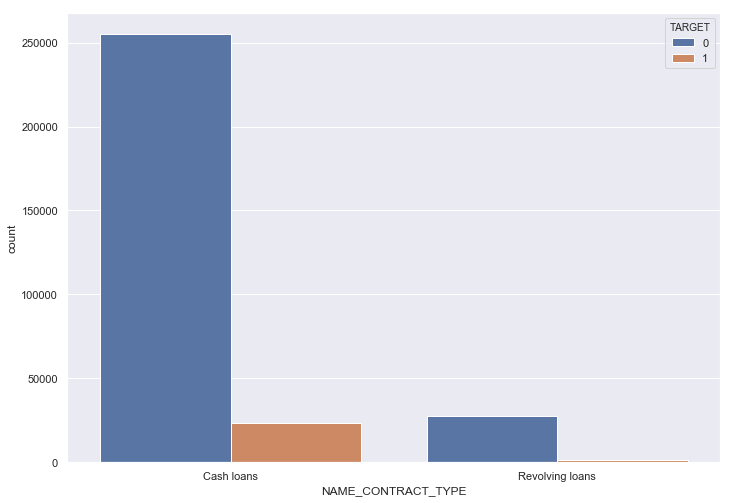

In [29]:
sns.countplot(x='NAME_CONTRACT_TYPE', hue='TARGET', data=application_train)

##### CODE_GENDER
Gender of the client

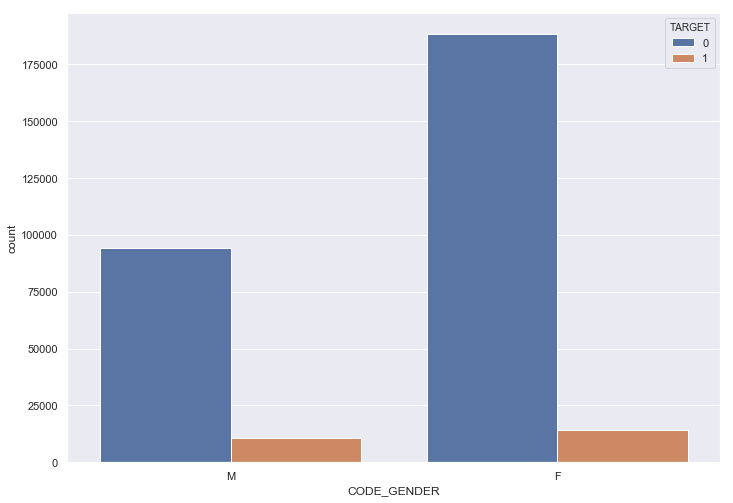

In [30]:
sns.countplot(x='CODE_GENDER', hue='TARGET', data=application_train)

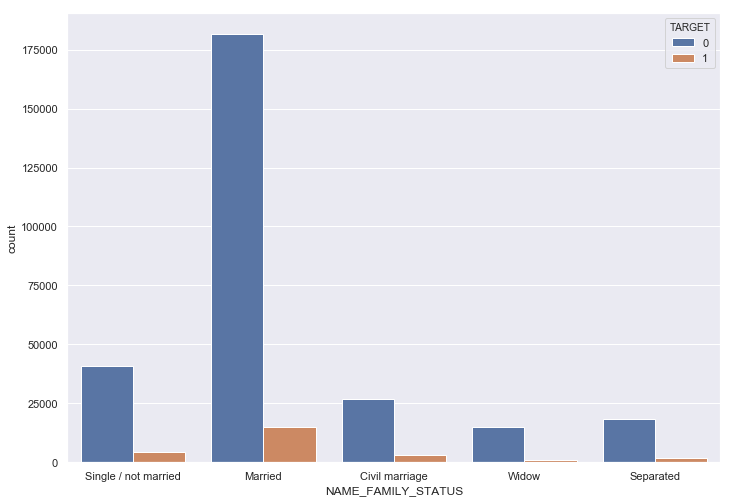

In [31]:
sns.countplot(x='NAME_FAMILY_STATUS', hue='TARGET', data=application_train)

##### FLAG_OWN_CAR
Flag if the client owns a car

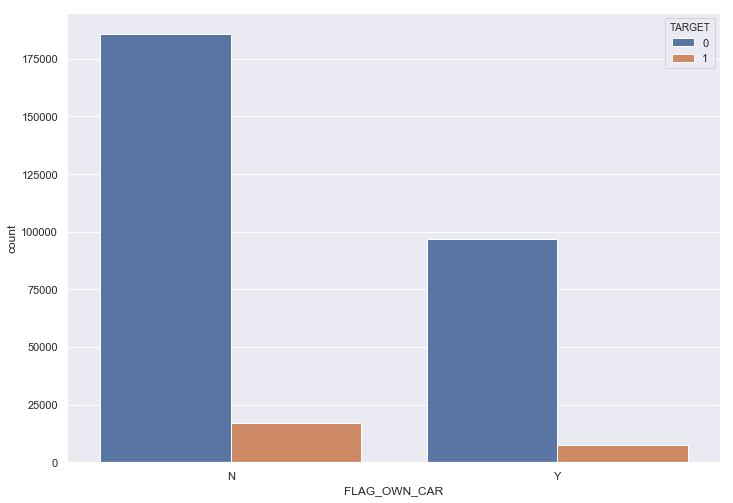

In [32]:
sns.countplot(x='FLAG_OWN_CAR', hue='TARGET', data=application_train)

##### FLAG_OWN_REALTY
Flag if client owns a house or flat

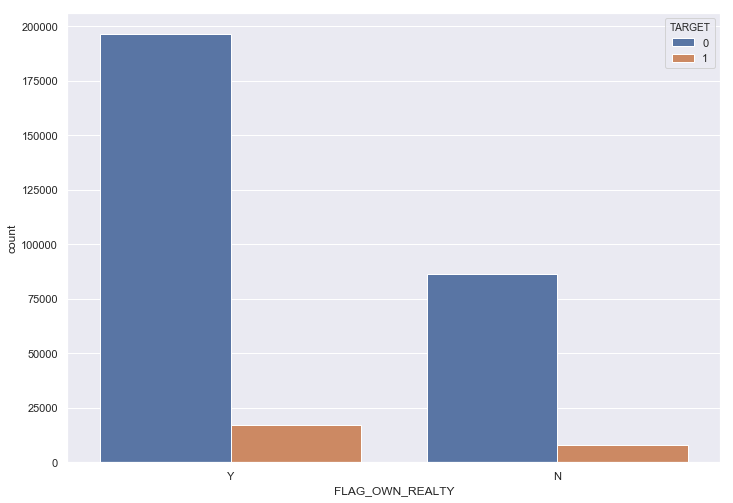

In [33]:
sns.countplot(x='FLAG_OWN_REALTY', hue='TARGET', data=application_train)

##### NAME_TYPE_SUITE
Who was accompanying client when he was applying for the loan

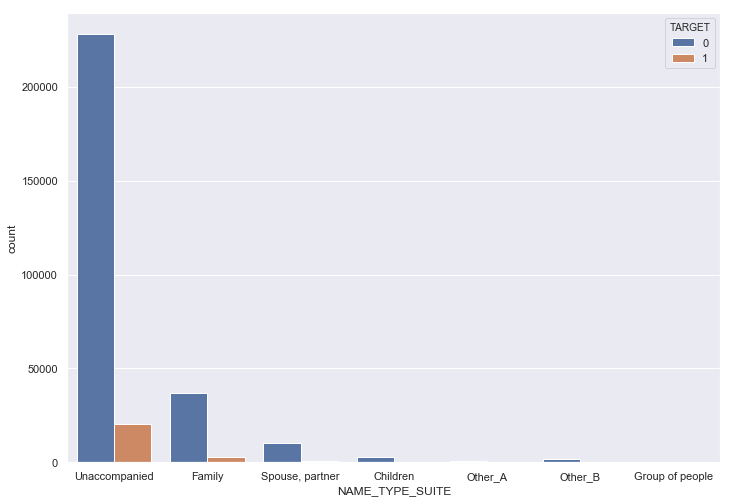

In [34]:
sns.countplot(x='NAME_TYPE_SUITE', hue='TARGET', data=application_train)

##### NAME_INCOME_TYPE
Clients income type (businessman, working, maternity leave,..)

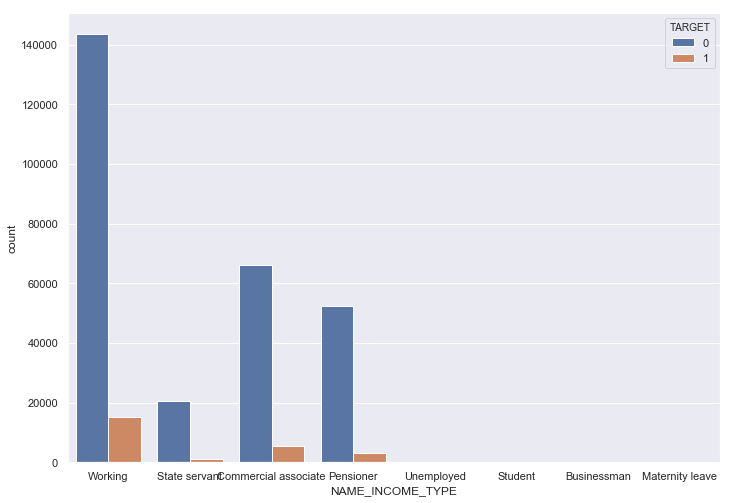

In [35]:
sns.countplot(x='NAME_INCOME_TYPE', hue='TARGET', data=application_train)

##### NAME_EDUCATION_TYPE
Level of highest education the client achieved

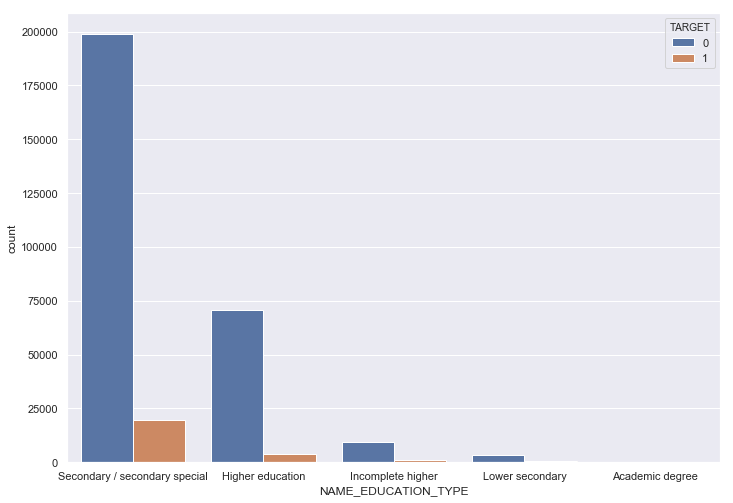

In [36]:
sns.countplot(x='NAME_EDUCATION_TYPE', hue='TARGET', data=application_train)

##### NAME_FAMILY_STATUS
Family status of the client

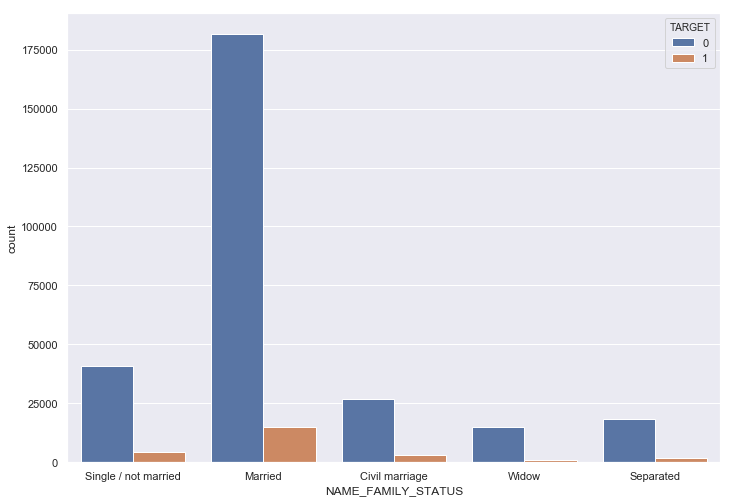

In [37]:
sns.countplot(x='NAME_FAMILY_STATUS', hue='TARGET', data=application_train)

##### NAME_HOUSING_TYPE
What is the housing situation of the client (renting, living with parents, ...)

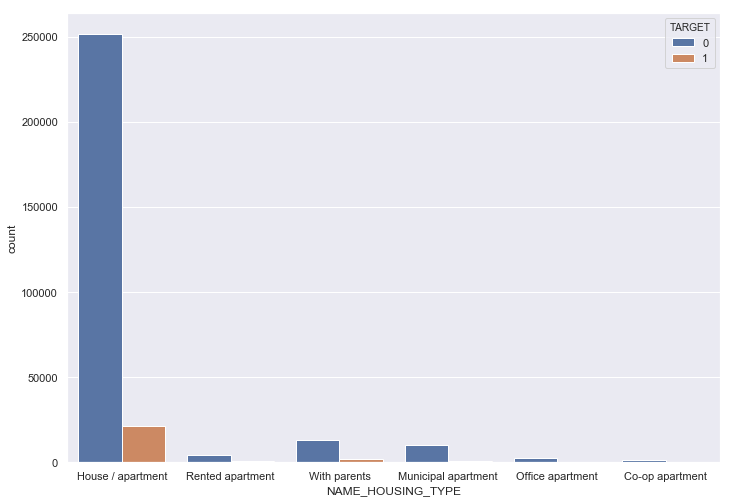

In [38]:
sns.countplot(x='NAME_HOUSING_TYPE', hue='TARGET', data=application_train)

##### OCCUPATION_TYPE
What kind of occupation does the client have

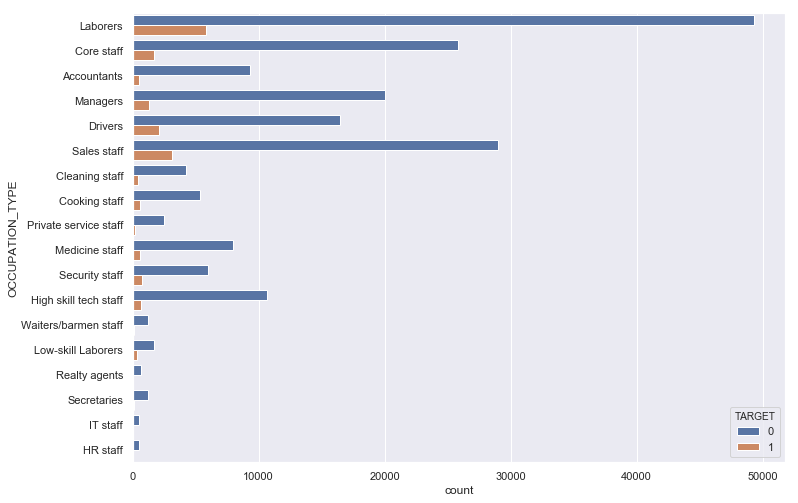

In [39]:
sns.countplot(y='OCCUPATION_TYPE', hue='TARGET', data=application_train)

##### WEEKDAY_APPR_PROCESS_START
On which day of the week did the client apply for the loan

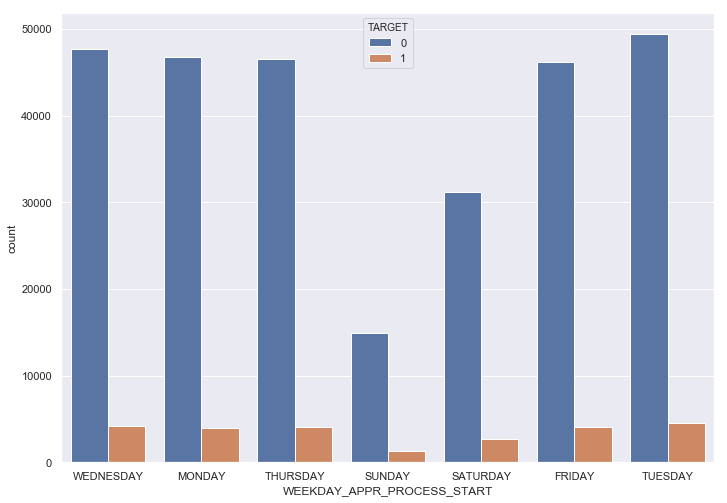

In [40]:
sns.countplot(x='WEEKDAY_APPR_PROCESS_START', hue='TARGET', data=application_train)

##### ORGANIZATION_TYPE
Type of organization where client works

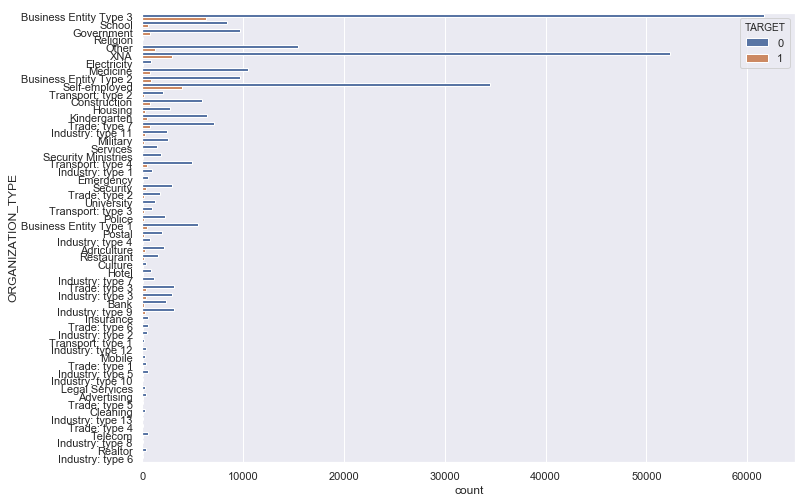

In [41]:
sns.countplot(y='ORGANIZATION_TYPE', hue='TARGET', data=application_train)

#### Numerical features
In this section, we will explore the numerical features 

##### AMT_INCOME_TOTAL
Income of the client

**Income distribution for the 0-800K range**

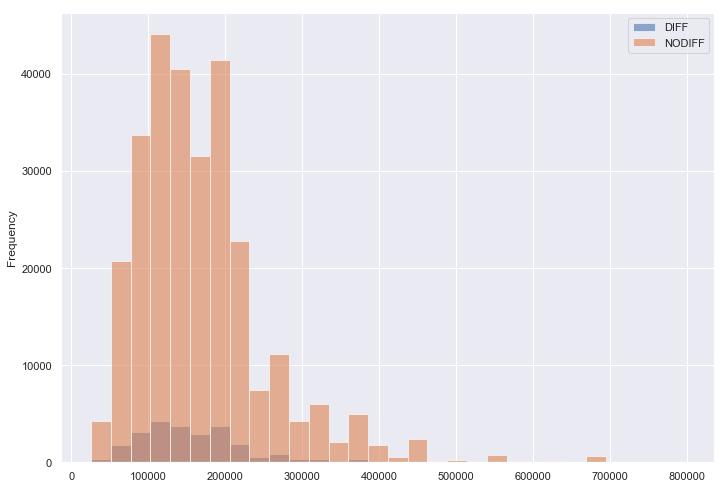

In [42]:
diff_AMT_INCOME_TOTAL = (application_train[application_train.TARGET == 1].AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL < 800000)])
nodiff_AMT_INCOME_TOTAL = (application_train[application_train.TARGET == 0].AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL < 800000)])

pd.DataFrame(
{'DIFF': diff_AMT_INCOME_TOTAL,
 'NODIFF': nodiff_AMT_INCOME_TOTAL},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 30,alpha=0.6)
plt.show()

**Income distribution for the 800K-2M range**

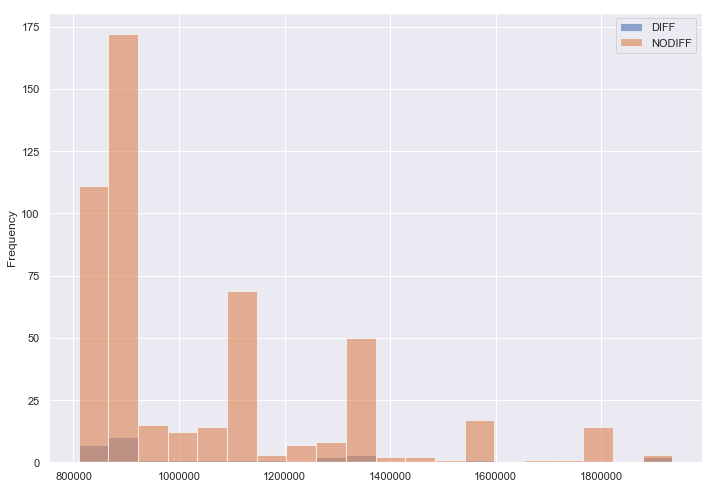

In [43]:
pd.DataFrame(
{'DIFF': application_train[application_train.TARGET == 1].AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 800000) & (application_train.AMT_INCOME_TOTAL < 2000000)],
 'NODIFF': application_train[application_train.TARGET == 0].AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 800000) & (application_train.AMT_INCOME_TOTAL < 2000000)]},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

**Income distribution for the 2M+ range**

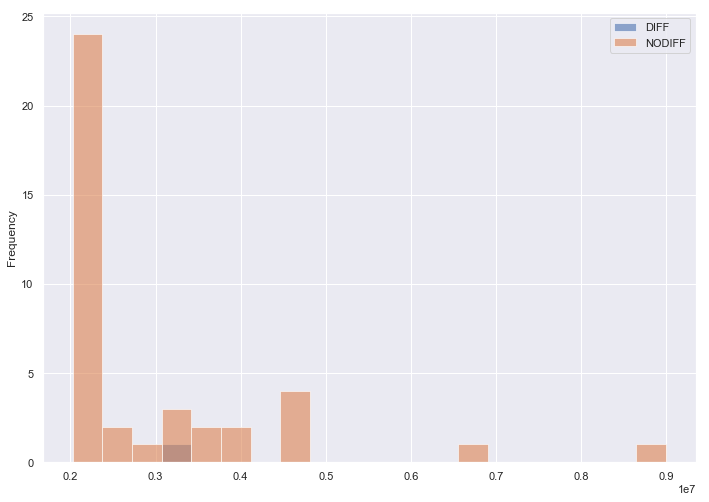

In [44]:
pd.DataFrame(
{'DIFF': application_train[application_train.TARGET == 1].AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 2000000)],
 'NODIFF': application_train[application_train.TARGET == 0].AMT_INCOME_TOTAL[(application_train.AMT_INCOME_TOTAL > 2000000)]},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

#### AMT_CREDIT
Credit amount of the loan

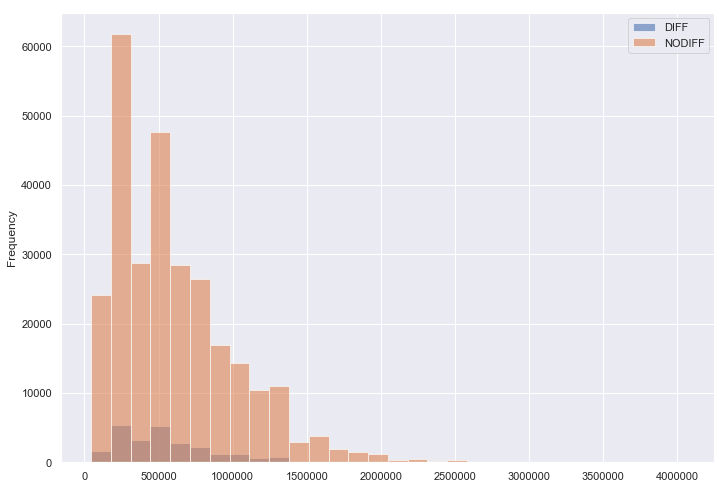

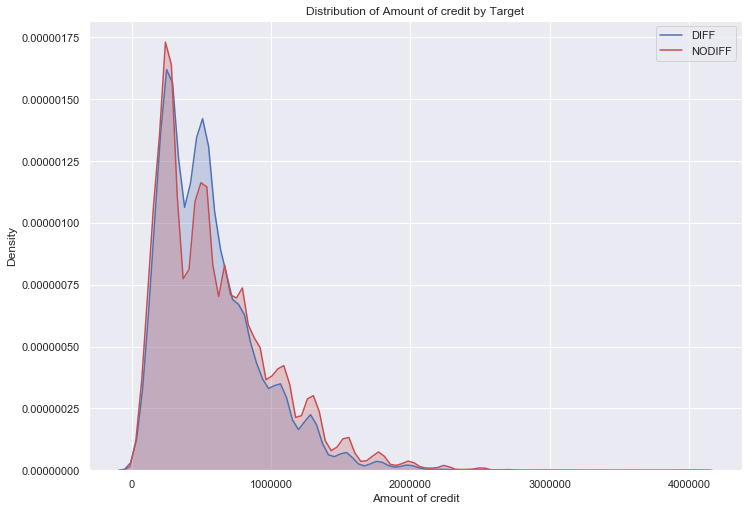

In [45]:
diff_AMT_CREDIT = application_train[(application_train.TARGET == 1) & (application_train.AMT_CREDIT.notnull())].AMT_CREDIT
nodiff_AMT_CREDIT = application_train[(application_train.TARGET == 0) & (application_train.AMT_CREDIT.notnull())].AMT_CREDIT

pd.DataFrame(
{'DIFF': diff_AMT_CREDIT,
 'NODIFF': nodiff_AMT_CREDIT},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 30,alpha=0.6)
plt.show()


plt.subplot(1, 1, 1)
sns.kdeplot(diff_AMT_CREDIT,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_AMT_CREDIT, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of Amount of credit by Target')
plt.xlabel('Amount of credit'); 
plt.ylabel('Density');

#### DAYS_BIRTH
Client's age in days at the time of application

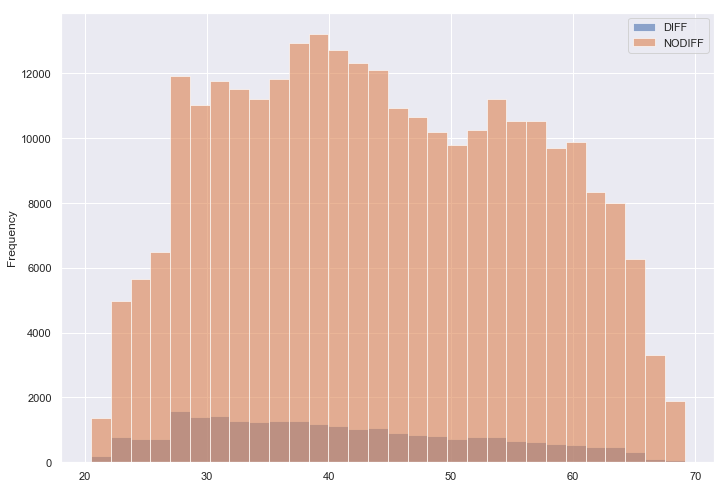

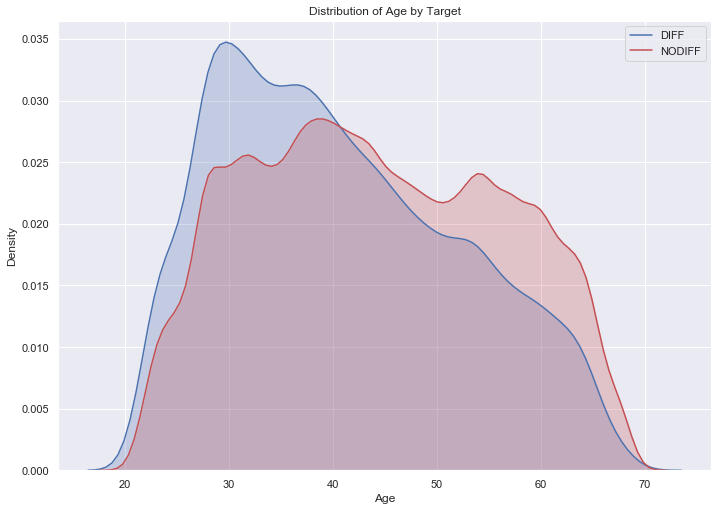

In [46]:
diff_DAYS_BIRTH = (application_train[application_train.TARGET == 1].DAYS_BIRTH/-365)
nodiff_DAYS_BIRTH = (application_train[application_train.TARGET == 0].DAYS_BIRTH/-365)

pd.DataFrame(
{'DIFF': diff_DAYS_BIRTH,
 'NODIFF': nodiff_DAYS_BIRTH},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 30,alpha=0.6)
plt.show()


plt.subplot(1, 1, 1)
sns.kdeplot(diff_DAYS_BIRTH,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_DAYS_BIRTH, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of Age by Target')
plt.xlabel('Age'); 
plt.ylabel('Density');

Younger people relatively have more difficulties

#### DAYS_EMPLOYED
How many days before the application the person started current employment

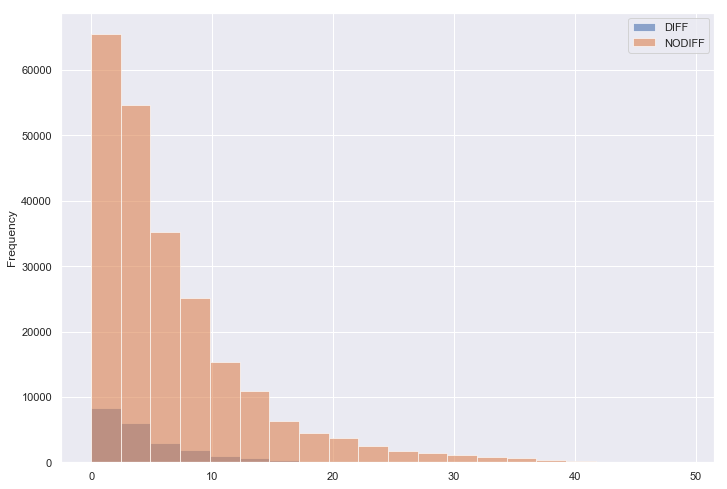

In [47]:
diff_DAYS_EMPLOYED = application_train[(application_train.TARGET == 1) & (application_train.DAYS_EMPLOYED.notnull())].DAYS_EMPLOYED/-365
nodiff_DAYS_EMPLOYED = application_train[(application_train.TARGET == 0) & (application_train.DAYS_EMPLOYED.notnull())].DAYS_EMPLOYED/-365

pd.DataFrame(
{'DIFF': diff_DAYS_EMPLOYED,
 'NODIFF': nodiff_DAYS_EMPLOYED},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

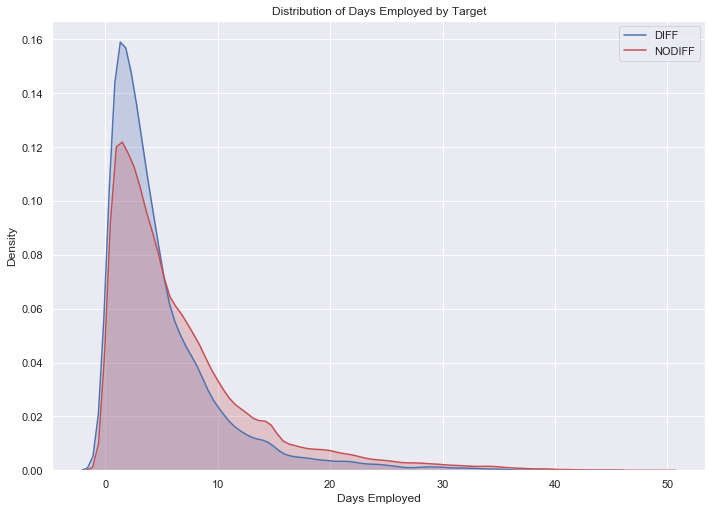

In [48]:
plt.subplot(1, 1, 1)
sns.kdeplot(diff_DAYS_EMPLOYED,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_DAYS_EMPLOYED, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of Days Employed by Target')
plt.xlabel('Days Employed'); 
plt.ylabel('Density');

 #### EXT_SOURCE_{1|2|3}
 Normalized score from external data source

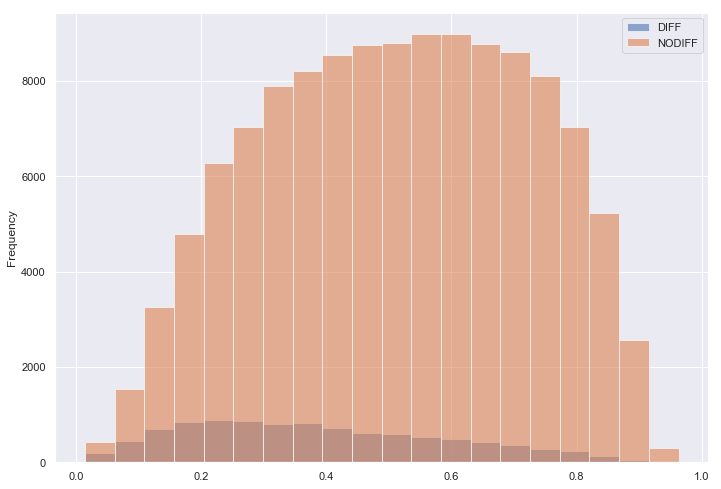

In [49]:
diff_EXT_SOURCE_1 = application_train[(application_train.TARGET == 1) & (application_train.EXT_SOURCE_1.notnull())].EXT_SOURCE_1
nodiff_EXT_SOURCE_1 = application_train[(application_train.TARGET == 0) & (application_train.EXT_SOURCE_1.notnull())].EXT_SOURCE_1


pd.DataFrame(
{'DIFF': diff_EXT_SOURCE_1
,
 'NODIFF': nodiff_EXT_SOURCE_1
},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

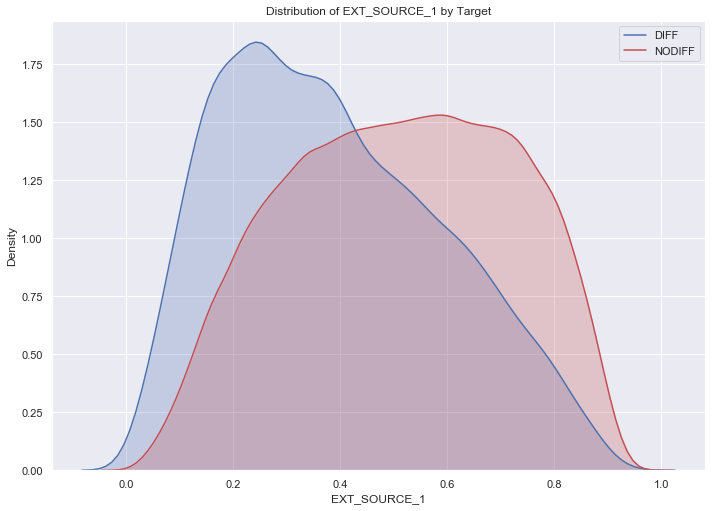

In [50]:
plt.subplot(1, 1, 1)
sns.kdeplot(diff_EXT_SOURCE_1,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_EXT_SOURCE_1, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of EXT_SOURCE_1 by Target')
plt.xlabel('EXT_SOURCE_1'); 
plt.ylabel('Density');

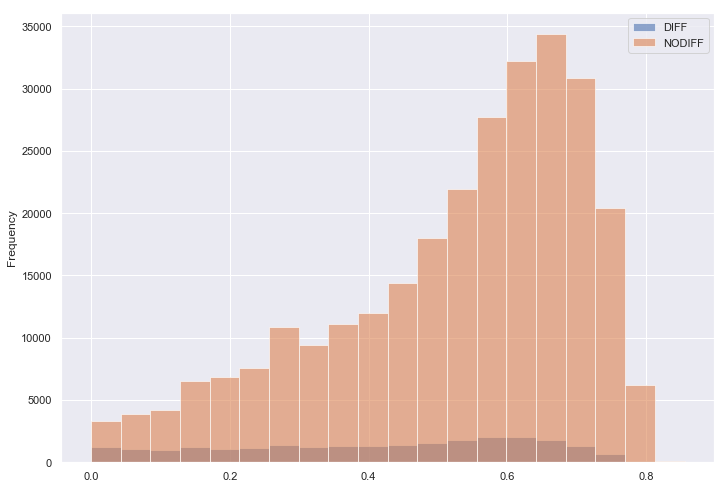

In [51]:
diff_EXT_SOURCE_2 = application_train[(application_train.TARGET == 1) & (application_train.EXT_SOURCE_2.notnull())].EXT_SOURCE_2
nodiff_EXT_SOURCE_2 = application_train[(application_train.TARGET == 0) & (application_train.EXT_SOURCE_2.notnull())].EXT_SOURCE_2


pd.DataFrame(
{'DIFF': diff_EXT_SOURCE_2
,
 'NODIFF': nodiff_EXT_SOURCE_2
},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

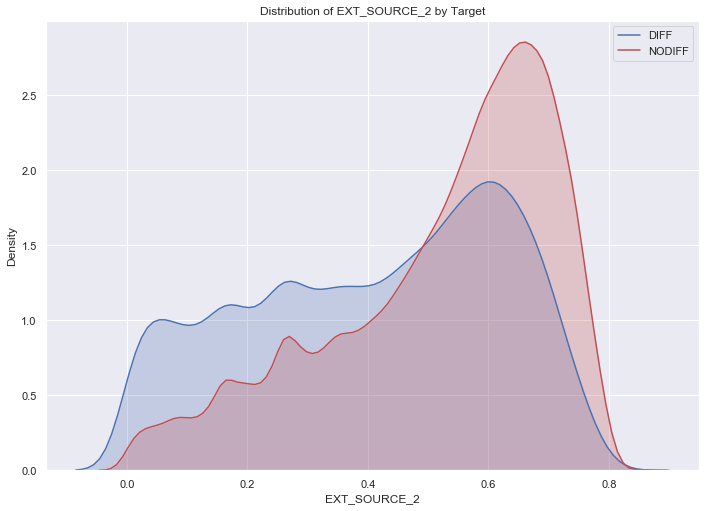

In [52]:
plt.subplot(1, 1, 1)
sns.kdeplot(diff_EXT_SOURCE_2,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_EXT_SOURCE_2, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of EXT_SOURCE_2 by Target')
plt.xlabel('EXT_SOURCE_2'); 
plt.ylabel('Density');

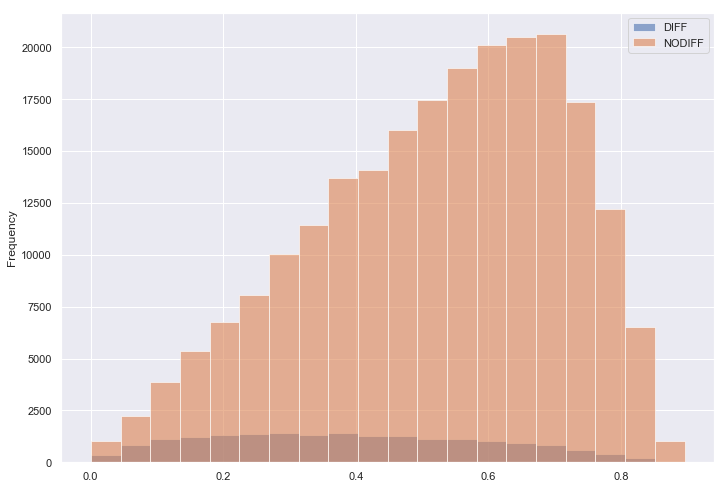

In [53]:
diff_EXT_SOURCE_3 = application_train[(application_train.TARGET == 1) & (application_train.EXT_SOURCE_3.notnull())].EXT_SOURCE_3
nodiff_EXT_SOURCE_3 = application_train[(application_train.TARGET == 0) & (application_train.EXT_SOURCE_3.notnull())].EXT_SOURCE_3
pd.DataFrame(
{'DIFF': diff_EXT_SOURCE_3
,
 'NODIFF': nodiff_EXT_SOURCE_3
},
columns=['DIFF','NODIFF']
).plot(kind = 'hist',bins = 20,alpha=0.6)
plt.show()

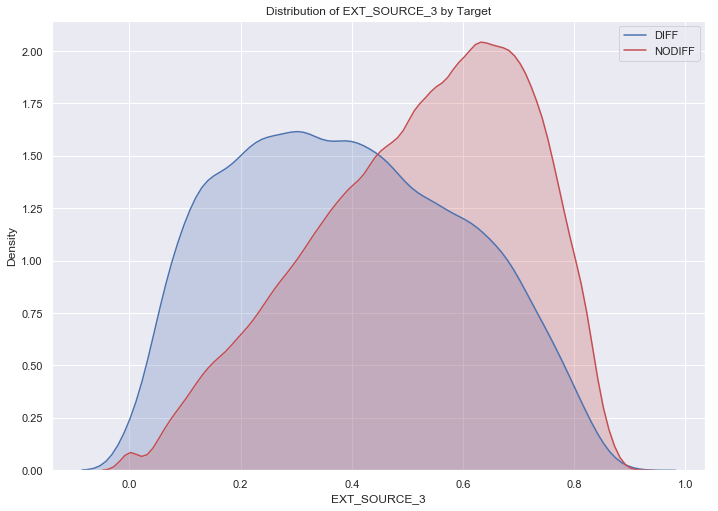

In [54]:
plt.subplot(1, 1, 1)
sns.kdeplot(diff_EXT_SOURCE_3,shade=True, color="b",label = 'DIFF')
sns.kdeplot(nodiff_EXT_SOURCE_3, shade=True, color="r", label = 'NODIFF')
plt.title('Distribution of EXT_SOURCE_3 by Target')
plt.xlabel('EXT_SOURCE_3'); 
plt.ylabel('Density');

Lower scores have more difficulties and vice versa.

---

### Data preparation
In this part, we will process our data (encode the categorical features, bin continuous features, deal with nulls.. etc)
We will focus on the following features: 
*AMT_INCOME_TOTAL,
AMT_CREDIT,
AMT_ANNUITY,
DAYS_BIRTH,
DAYS_EMPLOYED,
CNT_FAM_MEMBERS,
DAYS_LAST_PHONE_CHANGE,
OWN_CAR_AGE,

EXT_SOURCE_{1|2|3},
REGION_RATING_CLIENT,
REGION_RATING_CLIENT_W_CITY,
LIVE_REGION_NOT_WORK_REGION,
REG_CITY_NOT_LIVE_CITY,
REG_CITY_NOT_WORK_CITY,
LIVE_CITY_NOT_WORK_CITY,

NAME_CONTRACT_TYPE,
CODE_GENDER,
FLAG_OWN_CAR,
FLAG_OWN_REALTY,
NAME_TYPE_SUITE,
NAME_INCOME_TYPE,
NAME_EDUCATION_TYPE,
NAME_FAMILY_STATUS,
NAME_HOUSING_TYPE,
OCCUPATION_TYPE,
ORGANIZATION_TYPE*

In [55]:
categorical_features=[
    'FLAG_OWN_CAR',
    'CODE_GENDER',
    'FLAG_OWN_REALTY',
    'NAME_CONTRACT_TYPE',
    'NAME_TYPE_SUITE',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE',
    'REG_CITY_NOT_LIVE_CITY',
    'REG_CITY_NOT_WORK_CITY',
    'LIVE_CITY_NOT_WORK_CITY',
    'REGION_RATING_CLIENT',
    'REGION_RATING_CLIENT_W_CITY'
]

application_train_proc = application_train[['TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE','OWN_CAR_AGE'] + categorical_features]


In [59]:
for col in categorical_features:
    application_train_proc.loc[:,col], uniques = pd.factorize(application_train_proc[col])

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [60]:
application_train_proc.head()

,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,OWN_CAR_AGE,FLAG_OWN_CAR,CODE_GENDER,FLAG_OWN_REALTY,NAME_CONTRACT_TYPE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY
0,1,202500.0,406597.5,24700.5,-9461,-637.0,1.0,0.083037,0.262949,0.139376,-1134.0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,270000.0,1293502.5,35698.5,-16765,-1188.0,2.0,0.311267,0.622246,NaN,-828.0,NaN,0,1,1,0,1,1,1,1,0,1,1,0,0,0,1,1
2,0,67500.0,135000.0,6750.0,-19046,-225.0,1.0,NaN,0.555912,0.729567,-815.0,26.0,1,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0
3,0,135000.0,312682.5,29686.5,-19005,-3039.0,2.0,NaN,0.650442,NaN,-617.0,NaN,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0
4,0,121500.0,513000.0,21865.5,-19932,-3038.0,1.0,NaN,0.322738,NaN,-1106.0,NaN,0,0,0,0,0,0,0,0,0,1,3,0,1,1,0,0


### Correlation map

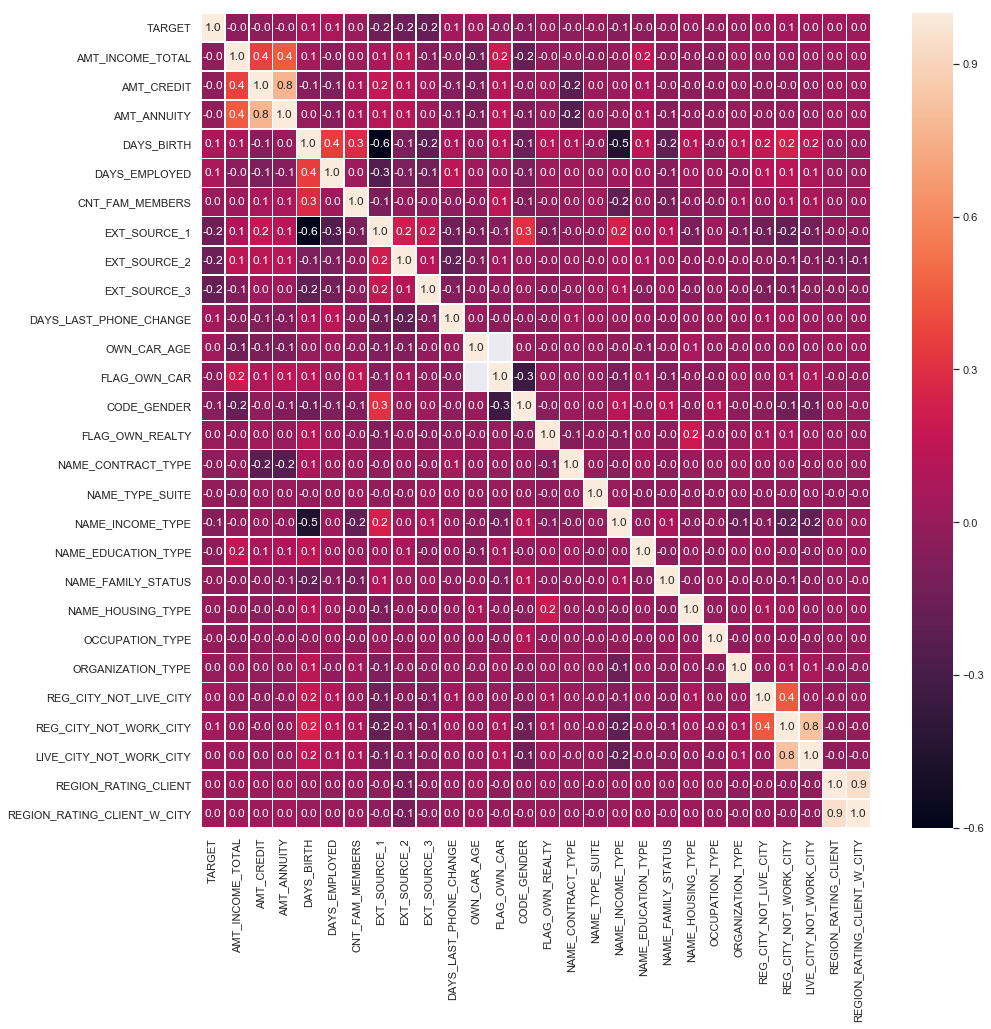

In [61]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(application_train_proc.corr(), annot=True, linewidths=.7, fmt= '.1f',ax=ax)
plt.show()

---

# Predictive model using Application table 
We will use features from the *'application'* table only to predict probabilities of credit default risk with the help of LightGBM.

## Using simple features
In this part, we will only use simple features for our predictions

In [62]:
n_folds = 5
folds = StratifiedKFold(n_splits= n_folds, shuffle=True, random_state= 666)

params ={
    'boosting_type': 'goss',
    'n_estimators': 10000,
    'learning_rate': 0.005,
    'num_leaves': 52,
    'max_depth': 12,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.45,
    'reg_lambda': 0.48,
    'colsample_bytree': 0.5,
    'min_split_gain': 0.025,
    'subsample': 1
}

In [63]:
def plot_roc_auc(fpr,tpr,roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def plot_feat_importance(feat_importance_df):
    cols = feat_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feat_importance_df.loc[feat_importance_df.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM feature importance (avg over folds)')
    

def lightgbm_model(df_train,categorical_feat,rounds=100):
    # Spliting training data into features/labels 
    app_train_proc_feat, app_train_proc_lbl = df_train.loc[:,df_train.columns != 'TARGET'], df_train.loc[:,'TARGET']

    avg_score = 0
    fprs = []
    tprs = []
    roc_aucs = []
    importance_df = pd.DataFrame()
    
    for n_fold, (train_idx, cv_idx) in enumerate(folds.split(app_train_proc_feat, app_train_proc_lbl)):
        # Train data
        train_feats = app_train_proc_feat.iloc[train_idx]
        train_lbls = app_train_proc_lbl.iloc[train_idx]

        # Cross-validation data
        cv_feats = app_train_proc_feat.iloc[cv_idx]
        cv_lbls = app_train_proc_lbl.iloc[cv_idx]
        
        # Features
        feats = app_train_proc_feat.columns

        # LightGBM classifier
        lgbm = LGBMClassifier(**params)

        start = time.time()
        # Fitting the model
        lgbm.fit(train_feats, train_lbls, eval_set=[(train_feats, train_lbls), (cv_feats, cv_lbls)],
                        eval_metric='auc', verbose=400, early_stopping_rounds=rounds,
                        feature_name=list(feats), categorical_feature=categorical_feat)
        end = time.time()

        # Testing the model on the CV data
        preds = lgbm.predict_proba(cv_feats, num_iteration=lgbm.best_iteration_)[:, 1]

        # Scores
        roc_auc = roc_auc_score(cv_lbls, preds)
        fpr, tpr, threshold = roc_curve(cv_lbls, preds)
        roc_auc = auc(fpr, tpr)
        
        fprs.append(fpr)
        tprs.append(tpr)
        roc_aucs.append(roc_auc)

        avg_score += (roc_auc/n_folds)
        
        # Feature importance
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = feats
        fold_importance["importance"] = lgbm.feature_importances_
        importance_df = pd.concat([importance_df, fold_importance], axis=0)
        

        print('Training time: %.2f seconds' % (end-start))
        print('Fold %2d AUC : %.6f' % (n_fold, roc_auc))

        del lgbm, train_feats, train_lbls, cv_feats, cv_lbls, fold_importance
        gc.collect()


    print('Average score on folds: %.6f' % avg_score)
    
    return avg_score, fprs, tprs, roc_aucs, importance_df



In [ ]:
avg_score, fprs, tprs, roc_aucs, feat_importance = lightgbm_model(application_train_proc,categorical_features,100)

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.248884	training's auc: 0.765076	valid_1's binary_logloss: 0.252206	valid_1's auc: 0.749224
[800]	training's binary_logloss: 0.241761	training's auc: 0.778439	valid_1's binary_logloss: 0.248378	valid_1's auc: 0.752702
[1200]	training's binary_logloss: 0.237559	training's auc: 0.789868	valid_1's binary_logloss: 0.24741	valid_1's auc: 0.754133
[1600]	training's binary_logloss: 0.23411	training's auc: 0.800348	valid_1's binary_logloss: 0.247009	valid_1's auc: 0.754995
[2000]	training's binary_logloss: 0.231058	training's auc: 0.809951	valid_1's binary_logloss: 0.246822	valid_1's auc: 0.755458
[2400]	training's binary_logloss: 0.228237	training's auc: 0.81878	valid_1's binary_logloss: 0.246723	valid_1's auc: 0.755689
Early stopping, best iteration is:
[2435]	training's binary_logloss: 0.228011	training's auc: 0.819486	valid_1's binary_logloss: 0.246701	valid_1's auc: 0.755756
Training time: 106

c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.
[400]	training's binary_logloss: 0.248379	training's auc: 0.766396	valid_1's binary_logloss: 0.25365	valid_1's auc: 0.742571
[800]	training's binary_logloss: 0.241178	training's auc: 0.779653	valid_1's binary_logloss: 0.250187	valid_1's auc: 0.746742
[1200]	training's binary_logloss: 0.236964	training's auc: 0.791138	valid_1's binary_logloss: 0.249373	valid_1's auc: 0.748375
[1600]	training's binary_logloss: 0.233485	training's auc: 0.801757	valid_1's binary_logloss: 0.249058	valid_1's auc: 0.74925
[2000]	training's binary_logloss: 0.230436	training's auc: 0.811289	valid_1's binary_logloss: 0.248957	valid_1's auc: 0.749523
Early stopping, best iteration is:
[1924]	training's binary_logloss: 0.230998	training's auc: 0.809512	valid_1's binary_logloss: 0.248954	valid_1's auc: 0.749556
Training time: 84.34 seconds
Fold  1 AUC : 0.749556


c:\users\mbouqsimi\appdata\local\programs\python\python36\lib\site-packages\lightgbm\basic.py:1190: UserWarning:

categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_INCOME_TYPE', 'NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY']



Training until validation scores don't improve for 100 rounds.


In [ ]:
plot_feat_importance(feat_importance)

In [ ]:
plot_roc_auc(fprs[3], tprs[3],roc_aucs[3])

We get an AUC of about 0.755 using LightGBM and basic features. Next we will try to come up with some engineered features to help improve this score!

## Using engineered features
In this part, we will use simple features as well as engineered features for our predictions

### Document count
A count of the documents provided by the client

In [ ]:
docs = [cl for cl in application_train.columns if 'FLAG_DOCUMENT_' in cl]
application_train_proc['DOC_COUNT'] = application_train[docs].replace(np.nan,0).sum(axis=1)

In [ ]:
corr = application_train_proc['TARGET'].corr(application_train_proc['DOC_COUNT'])
print('Document count correlation: %.4f' % corr)

### External sources product cube root
The cube root of the EXT_SOURCES_{1|2|3} product

In [ ]:
application_train_proc['EXT_SOURCES_PROD_CBRT'] = (application_train_proc['EXT_SOURCE_1']*application_train_proc['EXT_SOURCE_2']*application_train_proc['EXT_SOURCE_3'])**(1/3)

In [ ]:
corr = application_train_proc['TARGET'].corr(application_train_proc['EXT_SOURCES_PROD_CBRT'])
print('External sources product cube root correlation: %.4f' % corr)

### External sources statistics
Min, Max, Mean, Median and Variance of EXT_SOURCES_{1|2|3}

In [ ]:
for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
    feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
    application_train_proc[feature_name] = eval('np.{}'.format(function_name))(
        application_train_proc[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

In [ ]:
for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
    feature_name = 'EXT_SOURCES_{}'.format(function_name.upper())
    corr = application_train_proc['TARGET'].corr(application_train_proc[feature_name])
    print('External sources {} correlation: {}'.format(function_name, corr))

### Years to pay
Years left to pay off the credit

In [ ]:
application_train_proc['YEARS_TO_PAY'] = application_train_proc['AMT_CREDIT'] / application_train_proc['AMT_ANNUITY']

In [ ]:
corr = application_train_proc['TARGET'].corr(application_train_proc['YEARS_TO_PAY'])
print('Years to pay correlation: %.4f' % corr)

### Down Payment
The down payment for the loan

In [ ]:
application_train_proc['DOWN_PAYMENT'] = application_train['AMT_GOODS_PRICE']-application_train_proc['AMT_CREDIT']

In [ ]:
corr = application_train_proc['TARGET'].corr(application_train_proc['DOWN_PAYMENT'])
print('Down Payment correlation: %.4f' % corr)

### Ratios
Retios of various contiuous features with eachother

In [ ]:
application_train_proc['CREDIT_TO_GOODS_RATIO'] = application_train_proc['AMT_CREDIT']/application_train['AMT_GOODS_PRICE']

In [ ]:
corr = application_train_proc['TARGET'].corr(application_train_proc['CREDIT_TO_GOODS_RATIO'])
print('Credit To Goods Ratio correlation: %.4f' % corr)

In [ ]:
application_train_proc['ANNUITY_TO_INCOME_RATIO'] = application_train_proc['AMT_ANNUITY'] / application_train_proc['AMT_INCOME_TOTAL']

In [ ]:
corr = application_train_proc['TARGET'].corr(application_train_proc['ANNUITY_TO_INCOME_RATIO'])
print('Annuity To Income Ratio correlation: %.4f' % corr)

In [ ]:
application_train_proc['EMPLOYED_TO_BIRTH_RATIO'] = application_train_proc['DAYS_EMPLOYED'] / application_train_proc['DAYS_BIRTH']

In [ ]:
corr = application_train_proc['TARGET'].corr(application_train_proc['EMPLOYED_TO_BIRTH_RATIO'])
print('Employed To Birth Ratio correlation: %.4f' % corr)

In [ ]:
application_train_proc['CAR_TO_BIRTH_RATIO'] = application_train['OWN_CAR_AGE'] / application_train_proc['DAYS_BIRTH']

In [ ]:
corr = application_train_proc['TARGET'].corr(application_train_proc['CAR_TO_BIRTH_RATIO'])
print('Car To Birth Ratio correlation: %.4f' % corr)

In [ ]:
application_train_proc['CAR_TO_EMPLOYED_RATIO'] = application_train_proc['OWN_CAR_AGE'] / application_train_proc['DAYS_EMPLOYED']

In [ ]:
corr = application_train_proc['TARGET'].corr(application_train_proc['CAR_TO_EMPLOYED_RATIO'])
print('Car To Employed Ratio correlation: %.4f' % corr)

## Model fitting with the engineered features
Fitting the LightGBM model using the engineered features

In [ ]:
avg_score, fprs, tprs, roc_aucs, feat_importance = lightgbm_model(application_train_proc,categorical_features,100)

In [ ]:
plot_feat_importance(feat_importance)

We get an AUC of about 0.767 using the new features. Next we will go through the *'bureau'* tables to get more features

---

## Bureau table
In this part, we will explore the features provided by the 'bureau' table.

In [149]:
bureau = pd.read_csv('./datasets/bureau.csv').rename(index=str, columns={'AMT_ANNUITY': 'AMT_ANNUITY_BUREAU'})

In [150]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_BUREAU
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [94]:
bureau['CREDIT_ACTIVE'].value_counts()

Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64

In [95]:
bureau['CREDIT_CURRENCY'].value_counts()

currency 1    1715020
currency 2       1224
currency 3        174
currency 4         10
Name: CREDIT_CURRENCY, dtype: int64

In [96]:
bureau['CREDIT_TYPE'].value_counts()

Consumer credit                                 1251615
Credit card                                      402195
Car loan                                          27690
Mortgage                                          18391
Microloan                                         12413
Loan for business development                      1975
Another type of loan                               1017
Unknown type of loan                                555
Loan for working capital replenishment              469
Cash loan (non-earmarked)                            56
Real estate loan                                     27
Loan for the purchase of equipment                   19
Loan for purchase of shares (margin lending)          4
Interbank credit                                      1
Mobile operator loan                                  1
Name: CREDIT_TYPE, dtype: int64

### Feature engineering 
We will use various aggregation to come up with new features from the 'bureau' table

In [160]:
application_train_bureau = pd.merge(application_train, bureau, on='SK_ID_CURR', how='left')

In [161]:
application_train_bureau.groupby('SK_ID_CURR').head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_BUREAU
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0000,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,6158904.0,Closed,currency 1,-1125.0,0.0,-1038.0,-1038.0,NaN,0.0,40761.000,NaN,NaN,0.0,Credit card,-1038.0,0.0
1,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0000,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-11

In [162]:
application_train_bureau.groupby(['SK_ID_CURR'])['SK_ID_BUREAU'].agg('count').head(10)

SK_ID_CURR
100002     8
100003     4
100004     2
100006     0
100007     1
100008     3
100009    18
100010     2
100011     4
100012     0
Name: SK_ID_BUREAU, dtype: int64

#### Bad Debt Count
Count of all bad debts

In [165]:
bad_debt_dp = application_train_bureau[application_train_bureau.CREDIT_ACTIVE=='Bad debt'].groupby(['SK_ID_CURR'])['CREDIT_ACTIVE'].agg('count').reset_index(name='BAD_DEBT_CNT').head(30)

,SK_ID_CURR,BAD_DEBT_CNT
0,158069,1
1,163442,1
2,176952,1
3,186360,1
4,207535,1
5,231185,1
6,232061,1
7,243877,1
8,264970,1
9,273612,1


In [155]:
application_train_bureau = pd.merge(application_train_bureau, bad_debt_dp, on='SK_ID_CURR', how='left')

In [156]:
del bad_debt_dp
gc.collect()

7

#### Closed Credit Count
Count of all credit that is closed

In [157]:
closed_credit_dp = application_train_bureau[application_train_bureau.CREDIT_ACTIVE=='Closed'].groupby(['SK_ID_CURR','CREDIT_ACTIVE']).size().reset_index(name='CLOSED_CREDIT_CNT')

AttributeError: 'DataFrame' object has no attribute 'CREDIT_ACTIVE'

In [ ]:
application_train_bureau = pd.merge(application_train_bureau, closed_credit_dp, on='SK_ID_CURR', how='left')

In [ ]:
del closed_credit_dp
gc.collect()

In [158]:
application_train_bureau.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_BUREAU,CREDIT_ACTIVE_x,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_BUREAU,CREDIT_ACTIVE_y,BAD_DEBT_CNT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.0,0.069,0.0833,0.125,0.0369,0.0202,0.019,0.0,0.0,0.0252,0.0383,0.9722,0.6341,0.0144,0.0,0.069,0.0833,0.125,0.0377,0.022,0.0198,0.0,0.0,0.025,0.0369,0.9722,0.6243,0.0144,0.0,0.069,0.0833,0.125,0.0375,0.0205,0.0193,0.0,0.0,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,6158904.0,Closed,currency 1,-1125.0,0.0,-1038.0,-1038.0,NaN,0.0,40761.0,NaN,NaN,0.0,Credit card,-1038.0,0.0,NaN,NaN
1,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.0,0.069,0.0833,0.125,0.0369,0.0202,0.019,0.0,0.0,0.0252,0.0383,0.9722,0.6341,0.0144,0.0,0.069,0.0833,0.125,0.0377,0.022,0.0198,0.0,0.0,0.025,0.0369,0.9722,0.6243,0.0144,0.0,0.069,0.0833,0.125,0.0375,0.0205,0.0193,0.0,0.0,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,

In [108]:
bureau['CREDIT_ACTIVE'].unique().tolist()

['Closed', 'Active', 'Sold', 'Bad debt']

In [ ]:
.fillna({'CLOSED_CREDIT_CNT': 0, 'BAD_DEBT_CNT':0})